In [1]:
import sys
assert sys.version_info >= (3, 5)
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
import numpy as np
import time
K = keras.backend
import pandas as pd
import math
import os
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn 
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.colors as mcolors



tf.random.set_seed(42)
np.random.seed(42)
random_state=42

In [2]:
save_path = 'save_path'
os.chdir(save_path)

X_train_omics_unlabelled = pd.read_csv("X_train_omics_unlabelled.csv",index_col=0)
X_train_omics_labelled = pd.read_csv("X_train_omics_labelled.csv",index_col=0)
X_test_omics= pd.read_csv("X_test_omics.csv",index_col=0)
X_valid_omics= pd.read_csv("X_valid_omics.csv",index_col=0)
features = np.load("feature_selection.npy",allow_pickle=True)

train_set_labelled_y= pd.read_csv("train_set_labelled_y.csv",index_col=0)
test_set_labelled_y= pd.read_csv("test_set_labelled_y.csv",index_col=0)
valid_set_labelled_y= pd.read_csv("valid_set_labelled_y.csv",index_col=0)

X_train_omics_unlabelled = X_train_omics_unlabelled[features]
X_train_omics_labelled = X_train_omics_labelled[features]
X_test_omics = X_test_omics[features]
X_valid_omics = X_valid_omics[features]

train_set_labelled_c= pd.read_csv("train_set_labelled_c.csv",index_col=0)
train_set_unlabelled_c= pd.read_csv("train_set_unlabelled_c.csv",index_col=0)
test_set_labelled_c= pd.read_csv("test_set_labelled_c.csv",index_col=0)
valid_set_labelled_c= pd.read_csv("valid_set_labelled_c.csv",index_col=0)

train_set_labelled_c = train_set_labelled_c[["age","male"]]
train_set_unlabelled_c = train_set_unlabelled_c[["age","male"]]
test_set_labelled_c = test_set_labelled_c[["age","male"]]
valid_set_labelled_c = valid_set_labelled_c[["age","male"]]

scaler = MinMaxScaler()
train_set_labelled_y = scaler.fit_transform(train_set_labelled_y)
valid_set_labelled_y = scaler.transform(valid_set_labelled_y)
test_set_labelled_y = scaler.transform(test_set_labelled_y)

valid_set_labelled_y[np.where(valid_set_labelled_y >1)] = 1
test_set_labelled_y[np.where(test_set_labelled_y >1)] = 1

train_set_labelled_c["age"] = scaler.fit_transform(train_set_labelled_c[["age"]])
train_set_unlabelled_c["age"] = scaler.transform(train_set_unlabelled_c[["age"]])
test_set_labelled_c["age"] = scaler.transform(test_set_labelled_c[["age"]])
valid_set_labelled_c["age"] = scaler.transform(valid_set_labelled_c[["age"]])


In [3]:
input_shape = X_train_omics_labelled.shape[1]

# Load best model (MMD) # 

## Custom parts ##

In [4]:
class Sampling(keras.layers.Layer):
    """reparameterization trick"""
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var/2) + mean   
    
    
class y_dist(keras.layers.Layer):

    """
    Custom layer that is used to learn the parameters of the distribution over y.
    
    Outputs a loss. The loss is used for training. The loss is a GMM loss.
    The mean of this is then taken to provide a per batch loss. 
        
    """
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        
        
    def build(self,batch_input_shape):
        self.q1 = self.add_weight(name="q1",shape=[1,1],initializer="random_normal",trainable=True)
        self.q2 = self.add_weight(name="q2",shape=[1,1],initializer="random_normal",trainable=True)
        self.mu1 = self.add_weight(name="mu1",shape=[1,1],initializer="random_normal",trainable=True)
        self.mu2 = self.add_weight(name="mu2",shape=[1,1],initializer="random_normal",trainable=True)
        self.mu3 = self.add_weight(name="mu3",shape=[1,1],initializer="random_normal",trainable=True)
        self.tau1 = self.add_weight(name="tau1",shape=[1,1],initializer="random_normal",trainable=True)
        self.tau2 = self.add_weight(name="tau2",shape=[1,1],initializer="random_normal",trainable=True)
        self.tau3 = self.add_weight(name="tau3",shape=[1,1],initializer="random_normal",trainable=True)

        super().build(batch_input_shape)
    
    def call(self,X):
        concatenated = tf.concat([self.q1,self.q2,tf.constant(np.array(0.0).reshape(1,-1),dtype="float32")],axis=-1)
        p = K.exp(concatenated)
        p = tf.math.divide(p,K.sum(p))
        sigma_concatenated = tf.concat([self.tau1,self.tau2,self.tau3],axis=-1)
        sigma = K.exp(sigma_concatenated)
        likelihood = p[0][0]*gaussian_pdf(X,mean=self.mu1,sigma=sigma[0][0])+p[0][1]*gaussian_pdf(X,mean=self.mu2,sigma=sigma[0][1])+p[0][2]*gaussian_pdf(X,mean=self.mu3,sigma=sigma[0][2]) 
        loglik = tf.math.log(likelihood)
        loss = -loglik
        loss = tf.reduce_mean(loss)
        return loss
    
    def compute_output_shape(self,batch_input_shape):
        return tf.TensorShape(1)    
    

In [5]:
def gaussian_pdf(array,mean,sigma):
    part1 = tf.math.divide(tf.constant(np.array(1.0).reshape(1,-1),dtype="float32"),sigma*(2*math.pi)**0.5)
    part2 = K.exp(-0.5*tf.math.divide((array-mean),sigma)**2)
    return part1*part2

## Load model ##

In [6]:
save_model_path = 'save_model_path'
os.chdir(save_model_path)

variational_encoder = keras.models.load_model("variational_encoder.h5", custom_objects={
   "Sampling": Sampling
})
variational_decoder = keras.models.load_model("variational_decoder.h5")
classifier = keras.models.load_model("classifier.h5", custom_objects={
   "Sampling": Sampling
})     
y_distribution = keras.models.load_model("y_distribution.h5", custom_objects={
   "y_dist": y_dist
})    

#for the loaded MMD model. Hyperparameters can be found in the relevant notebook.
codings_size=171

In [7]:
save_figure_path= 'save_figure_path'
os.chdir(save_figure_path)

# TSNE Visualisations #

In [8]:
tsne = TSNE(random_state=42)

In [9]:
########### preparation of data #################

######## training data #############

x_val_len = len(X_train_omics_labelled)
z = np.random.normal(loc=0,scale=1,size=codings_size*x_val_len).reshape(x_val_len,codings_size)
x_train_synthetic = variational_decoder([z,train_set_labelled_y,train_set_labelled_c.to_numpy()])
train_x = np.concatenate((X_train_omics_labelled.to_numpy(),x_train_synthetic))

######## val data ##############
x_val_len = len(X_valid_omics)
z = np.random.normal(loc=0,scale=1,size=codings_size*x_val_len).reshape(x_val_len,codings_size)
x_valid_synthetic = variational_decoder([z,valid_set_labelled_y,valid_set_labelled_c.to_numpy()])
valid_x = np.concatenate((X_valid_omics.to_numpy(),x_valid_synthetic))

######### test data #########
x_val_len = len(X_test_omics)
z = np.random.normal(loc=0,scale=1,size=codings_size*x_val_len).reshape(x_val_len,codings_size)
x_test_synthetic = variational_decoder([z,test_set_labelled_y,test_set_labelled_c.to_numpy()])
test_x = np.concatenate((X_test_omics.to_numpy(),x_test_synthetic))

In [10]:
omics_tsne = tsne.fit_transform(np.vstack([train_x,valid_x,test_x]))

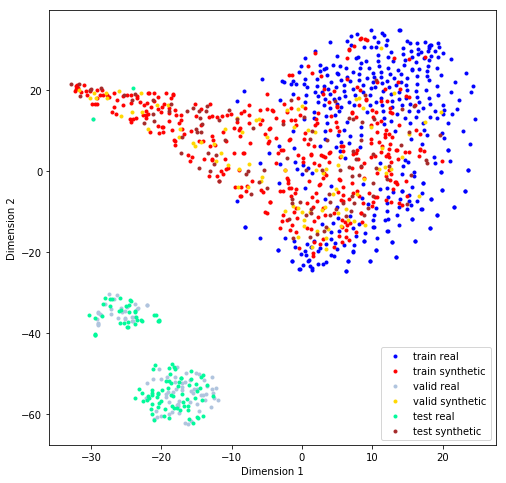

In [12]:
#set axis well

fig= plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)

ax1.scatter(x=omics_tsne[0:383,0],y=omics_tsne[0:383,1],c="blue",marker=".",label="train real") #real train
ax1.scatter(x=omics_tsne[383:766,0],y=omics_tsne[383:766,1],c="red",marker=".",label="train synthetic") #fake train
ax1.scatter(x=omics_tsne[766:854,0],y=omics_tsne[766:854,1],c="lightsteelblue",marker=".",label="valid real") #real valid
ax1.scatter(x=omics_tsne[854:942,0],y=omics_tsne[854:942,1],c="gold",marker=".",label="valid synthetic") #fake valid
ax1.scatter(x=omics_tsne[942:1048,0],y=omics_tsne[942:1048,1],c="mediumspringgreen",marker=".",label="test real") #real test
ax1.scatter(x=omics_tsne[1048:,0],y=omics_tsne[1048:,1],c="brown",marker=".",label="test synthetic") #fake test
ax1.set(xlabel="Dimension 1",ylabel="Dimension 2")
#ax1.set_xlim([-70,70])
#ax1.set_ylim([-40,40])


plt.legend(loc="lower right")
plt.savefig("tsne.pdf")
plt.savefig("tsne.png")

plt.show()

Data in its own cluster is mainly valid or test data which we don't see in training.

# Histograms #

## All data ##

### methylation intensities ###

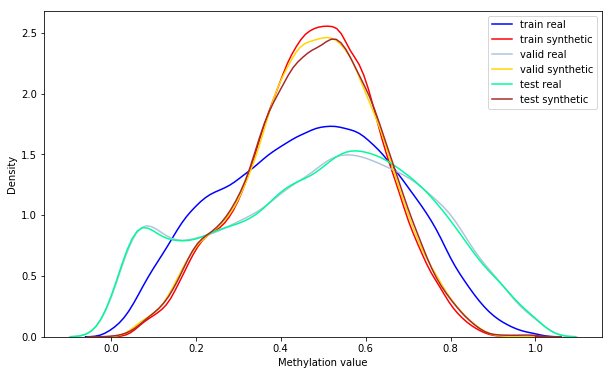

In [13]:
fig= plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)


seaborn.distplot(X_train_omics_labelled.to_numpy(),color="blue",hist=False,label = "train real")
seaborn.distplot(x_train_synthetic,color="red",hist=False,label="train synthetic")
seaborn.distplot(X_valid_omics.to_numpy(),color="lightsteelblue",hist=False,label="valid real")
seaborn.distplot(x_valid_synthetic,color="gold",hist=False,label="valid synthetic")
seaborn.distplot(X_test_omics.to_numpy(),color="mediumspringgreen",hist=False,label="test real")
seaborn.distplot(x_test_synthetic,color="brown",hist=False,label="test synthetic")

ax1.set(xlabel="Methylation value",ylabel="Density")

plt.legend(loc="upper right")

plt.savefig("dnam_hist.pdf")
plt.savefig("dnam_hist.png")

### methylation ranges ###

In [14]:
def methylation_ranges(numpy_array,top_percentile=95,bottom_percentile=5):
    return np.percentile(numpy_array,top_percentile,axis=0) - np.percentile(numpy_array,bottom_percentile,axis=0)

In [15]:
train_real = methylation_ranges(X_train_omics_labelled)
train_synthetic = methylation_ranges(x_train_synthetic)
valid_real = methylation_ranges(X_valid_omics)
valid_synthetic = methylation_ranges(x_valid_synthetic)
test_real = methylation_ranges(X_test_omics)
test_synthetic = methylation_ranges(x_test_synthetic)


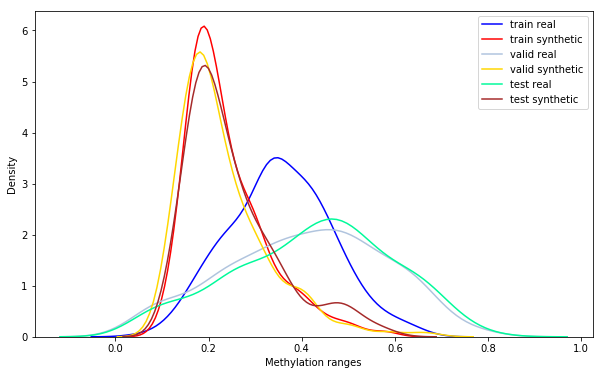

In [16]:
fig= plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)


seaborn.distplot(train_real,color="blue",hist=False,label = "train real")
seaborn.distplot(train_synthetic,color="red",hist=False,label="train synthetic")
seaborn.distplot(valid_real,color="lightsteelblue",hist=False,label="valid real")
seaborn.distplot(valid_synthetic,color="gold",hist=False,label="valid synthetic")
seaborn.distplot(test_real,color="mediumspringgreen",hist=False,label="test real")
seaborn.distplot(test_synthetic,color="brown",hist=False,label="test synthetic")

ax1.set(xlabel="Methylation ranges",ylabel="Density")

plt.legend(loc="upper right")

plt.savefig("dnam_range_hist.pdf")
plt.savefig("dnam_range_hist.png")

### change in no2 ###

#### Looking at max change in NO2 ####

##### old male ####

In [17]:
########### create synthetic data ##############

samples = 3000
z = np.random.normal(loc=0,scale=1,size=codings_size*samples).reshape(samples,codings_size)
y = np.array([1.0]).reshape(1,1)
y_max = np.repeat(y,repeats=samples,axis=0).reshape(-1,1)
c = np.array([1.0,1.0]).reshape(1,2)
c_max = np.repeat(c,repeats=samples,axis=0)
synthetic_max = variational_decoder([z,y_max,c_max])

y_min = np.repeat(0.0,repeats=samples,axis=0).reshape(-1,1)
synthetic_min = variational_decoder([z,y_min,c_max])

difference = synthetic_max - synthetic_min

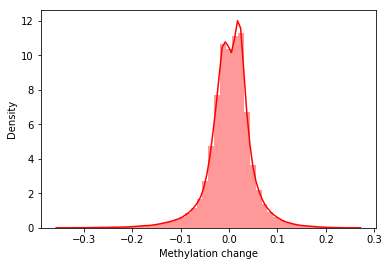

In [18]:
fig= plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(111)
seaborn.distplot(difference,color="red")
ax1.set(xlabel="Methylation change",ylabel="Density")
plt.savefig("max_change_no2.pdf")
plt.savefig("max_change_no2.png")

In [19]:
cpg_sites = X_train_omics_labelled.iloc[:,np.argsort(np.mean(difference,axis=0))].columns
mean_difference = np.sort(np.mean(difference,axis=0))
column_argument = np.argsort(np.mean(difference,axis=0))
d = {"CpG site": cpg_sites, "mean methylation difference": mean_difference,"column": column_argument}
dataframe = pd.DataFrame(data=d)
dataframe.set_index("CpG site",inplace=True)


In [20]:
#top 5 CpG sites that become more negative on increasing no2
dataframe.iloc[:5]

,column,mean methylation difference
CpG site,,
cg08347183,226,-0.096326
cg11322251,117,-0.088399
cg08675092,220,-0.086107
cg08797454,133,-0.079710
cg27393925,154,-0.078109


In [21]:
#top 5 CpG sites that become more positive on increasing no2
dataframe.iloc[-5:]

,column,mean methylation difference
CpG site,,
cg09077672,195,0.078619
cg22588546,136,0.086546
cg26532499,257,0.089658
cg00712106,194,0.090683
cg10783050,224,0.095665


##### old female #####

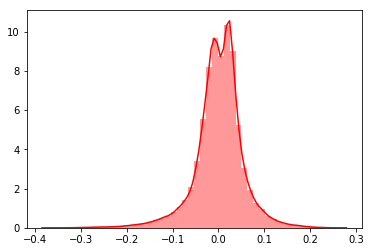

In [73]:
########### create synthetic data ##############

samples = 3000
z = np.random.normal(loc=0,scale=1,size=codings_size*samples).reshape(samples,codings_size)
y = np.array([1.0]).reshape(1,1)
y_max = np.repeat(y,repeats=samples,axis=0).reshape(-1,1)
c = np.array([1.0,0.0]).reshape(1,2)
c_max = np.repeat(c,repeats=samples,axis=0)
synthetic_max = variational_decoder([z,y_max,c_max])

y_min = np.repeat(0.0,repeats=samples,axis=0).reshape(-1,1)
synthetic_min = variational_decoder([z,y_min,c_max])

difference = synthetic_max - synthetic_min
seaborn.distplot(difference,color="red")

In [74]:
cpg_sites = X_train_omics_labelled.iloc[:,np.argsort(np.mean(difference,axis=0))].columns
mean_difference = np.sort(np.mean(difference,axis=0))
column_argument = np.argsort(np.mean(difference,axis=0))
d = {"CpG site": cpg_sites, "mean methylation difference": mean_difference,"column": column_argument}
dataframe = pd.DataFrame(data=d)
dataframe.set_index("CpG site",inplace=True)

In [75]:
#top 5 CpG sites that become more negative on increasing no2
dataframe.iloc[:5]

,column,mean methylation difference
CpG site,,
cg08347183,226,-0.117695
cg11322251,117,-0.107093
cg08675092,220,-0.105533
cg04921814,242,-0.099935
cg20401521,66,-0.095508


In [76]:
#top 5 CpG sites that become more positive on increasing no2
dataframe.iloc[-5:]

,column,mean methylation difference
CpG site,,
cg19586199,222,0.092757
cg26532499,257,0.101114
cg22588546,136,0.102059
cg00712106,194,0.107198
cg10783050,224,0.107540


Matches well with old male 

##### young female #####

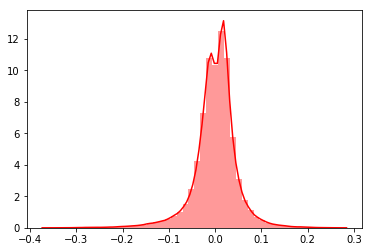

In [82]:
########### create synthetic data ##############

samples = 3000
z = np.random.normal(loc=0,scale=1,size=codings_size*samples).reshape(samples,codings_size)
y = np.array([1.0]).reshape(1,1)
y_max = np.repeat(y,repeats=samples,axis=0).reshape(-1,1)
c = np.array([0.0,0.0]).reshape(1,2)
c_max = np.repeat(c,repeats=samples,axis=0)
synthetic_max = variational_decoder([z,y_max,c_max])

y_min = np.repeat(0.0,repeats=samples,axis=0).reshape(-1,1)
synthetic_min = variational_decoder([z,y_min,c_max])

difference = synthetic_max - synthetic_min
seaborn.distplot(difference,color="red")

In [83]:
cpg_sites = X_train_omics_labelled.iloc[:,np.argsort(np.mean(difference,axis=0))].columns
mean_difference = np.sort(np.mean(difference,axis=0))
column_argument = np.argsort(np.mean(difference,axis=0))
d = {"CpG site": cpg_sites, "mean methylation difference": mean_difference,"column": column_argument}
dataframe = pd.DataFrame(data=d)
dataframe.set_index("CpG site",inplace=True)

In [84]:
#top 5 CpG sites that become more negative on increasing no2
dataframe.iloc[:5]

,column,mean methylation difference
CpG site,,
cg08347183,226,-0.098364
cg04921814,242,-0.094690
cg08675092,220,-0.094180
cg11322251,117,-0.085467
cg20401521,66,-0.084919


In [85]:
#top 5 CpG sites that become more positive on increasing no2
dataframe.iloc[-5:]

,column,mean methylation difference
CpG site,,
cg19586199,222,0.074249
cg22588546,136,0.080636
cg26532499,257,0.082385
cg10783050,224,0.082985
cg00712106,194,0.084771


Again matches well. 

##### young male #####

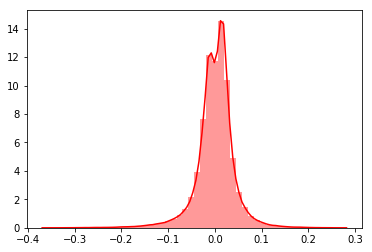

In [86]:
########### create synthetic data ##############

samples = 3000
z = np.random.normal(loc=0,scale=1,size=codings_size*samples).reshape(samples,codings_size)
y = np.array([1.0]).reshape(1,1)
y_max = np.repeat(y,repeats=samples,axis=0).reshape(-1,1)
c = np.array([0.0,1.0]).reshape(1,2)
c_max = np.repeat(c,repeats=samples,axis=0)
synthetic_max = variational_decoder([z,y_max,c_max])

y_min = np.repeat(0.0,repeats=samples,axis=0).reshape(-1,1)
synthetic_min = variational_decoder([z,y_min,c_max])

difference = synthetic_max - synthetic_min
seaborn.distplot(difference,color="red")

In [87]:
cpg_sites = X_train_omics_labelled.iloc[:,np.argsort(np.mean(difference,axis=0))].columns
mean_difference = np.sort(np.mean(difference,axis=0))
column_argument = np.argsort(np.mean(difference,axis=0))
d = {"CpG site": cpg_sites, "mean methylation difference": mean_difference,"column": column_argument}
dataframe = pd.DataFrame(data=d)
dataframe.set_index("CpG site",inplace=True)

In [88]:
#top 5 CpG sites that become more negative on increasing no2
dataframe.iloc[:5]

,column,mean methylation difference
CpG site,,
cg08347183,226,-0.081612
cg08675092,220,-0.078489
cg04921814,242,-0.077086
cg11322251,117,-0.070850
cg20401521,66,-0.068704


In [89]:
#top 5 CpG sites that become more positive on increasing no2
dataframe.iloc[-5:]

,column,mean methylation difference
CpG site,,
cg02586830,99,0.063483
cg22588546,136,0.068164
cg00712106,194,0.071233
cg26532499,257,0.072818
cg10783050,224,0.073248


### TSNE plots ###

In [22]:
#old female, max no2
samples = 1000
z = np.random.normal(loc=0,scale=1,size=codings_size*samples).reshape(samples,codings_size)
c = np.array([1.0,0.0]).reshape(1,2)
c = np.repeat(c,repeats=samples,axis=0)
y_value = np.repeat(1.0,repeats=samples,axis=0).reshape(-1,1)
old_female_max_y = variational_decoder([z,y_value,c])

#young female, max no2
z = np.random.normal(loc=0,scale=1,size=codings_size*samples).reshape(samples,codings_size)
c = np.array([0.0,0.0]).reshape(1,2)
c = np.repeat(c,repeats=samples,axis=0)
y_value = np.repeat(1.0,repeats=samples,axis=0).reshape(-1,1)
young_female_max_y = variational_decoder([z,y_value,c])

#young male, min no2
z = np.random.normal(loc=0,scale=1,size=codings_size*samples).reshape(samples,codings_size)
c = np.array([0.0,1.0]).reshape(1,2)
c = np.repeat(c,repeats=samples,axis=0)
y_value = np.repeat(0.0,repeats=samples,axis=0).reshape(-1,1)
young_male_min_y = variational_decoder([z,y_value,c])


#young male, max no2
z = np.random.normal(loc=0,scale=1,size=codings_size*samples).reshape(samples,codings_size)
c = np.array([0.0,1.0]).reshape(1,2)
c = np.repeat(c,repeats=samples,axis=0)
y_value = np.repeat(1.0,repeats=samples,axis=0).reshape(-1,1)
young_male_max_y = variational_decoder([z,y_value,c])

#old male, min no2
z = np.random.normal(loc=0,scale=1,size=codings_size*samples).reshape(samples,codings_size)
c = np.array([1.0,1.0]).reshape(1,2)
c = np.repeat(c,repeats=samples,axis=0)
y_value = np.repeat(0.0,repeats=samples,axis=0).reshape(-1,1)
old_male_min_y = variational_decoder([z,y_value,c])



omics_tsne = tsne.fit_transform(np.vstack([old_female_max_y,young_female_max_y,young_male_min_y,young_male_max_y,old_male_min_y]))

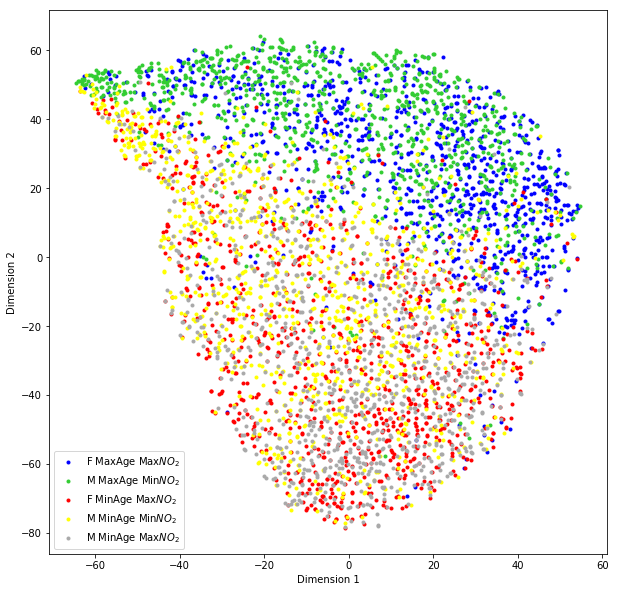

In [26]:
#set axis well

fig= plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)

ax1.scatter(x=omics_tsne[0:1000,0],y=omics_tsne[0:1000,1],c="blue",marker=".",label="F MaxAge Max$NO_{2}$") 
ax1.scatter(x=omics_tsne[4000:,0],y=omics_tsne[4000:,1],c="limegreen",marker=".",label="M MaxAge Min$NO_{2}$") 
ax1.scatter(x=omics_tsne[1000:2000,0],y=omics_tsne[1000:2000,1],c="red",marker=".",label="F MinAge Max$NO_{2}$") 
ax1.scatter(x=omics_tsne[2000:3000,0],y=omics_tsne[2000:3000,1],c="yellow",marker=".",label="M MinAge Min$NO_{2}$")
ax1.scatter(x=omics_tsne[3000:4000,0],y=omics_tsne[3000:4000,1],c="darkgrey",marker=".",label="M MinAge Max$NO_{2}$") 



ax1.set(xlabel="Dimension 1",ylabel="Dimension 2")
#ax1.set_xlim([-70,70])
#ax1.set_ylim([-40,40])


plt.legend(loc="lower left")
plt.savefig("tsne_comparisons.pdf")
plt.savefig("tsne_comparisons.png")
plt.show()